In [4]:
########## 1. Import required libraries ##########
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [5]:
########## 2. Define Text Preprocessing Functions ##########
def preprocess_text(text):
    """Clean raw text data."""
    if pd.isna(text):
        return ""
    # Remove HTML tags
    text = re.compile(r'<.*?>').sub('', text)
    # Remove emojis
    text = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF]+').sub('', text)
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text).lower().strip()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text

In [9]:
project = 'Title+Body'
data = pd.read_csv(f'{project}.csv')

# Check if 'text' and 'sentiment' exist
if 'text' in data.columns and 'sentiment' in data.columns:
    data = data[['text', 'sentiment']].dropna()
else:
    raise ValueError("Missing required columns: 'text' or 'sentiment'.")

# Optional: Apply text preprocessing if the function exists
if 'preprocess_text' in globals():
    data['text'] = data['text'].apply(preprocess_text)

print("Data successfully loaded and preprocessed!")


Data successfully loaded and preprocessed!


In [10]:
########## 4. Configure TF-IDF and Model Pipeline ##########
tfidf_params = {
    'ngram_range': (1, 3),      # Capture unigrams, bigrams, and trigrams
    'max_features': 5000,       # Increase feature dimension
    'stop_words': 'english',    # Use built-in English stopwords
    'sublinear_tf': True        # Apply sublinear TF scaling
}

# Build pipeline: TF-IDF -> SMOTE -> SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(class_weight='balanced', kernel='linear', random_state=42))
])

In [11]:
########## 5. Hyperparameter Tuning with GridSearchCV ##########
param_grid = {
    'svm__C': [0.1, 1, 10],        # Regularization strength
    'svm__gamma': ['scale', 'auto'] # Kernel coefficient (for non-linear kernels)
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)


In [12]:
########## 6. Train & Evaluate Model (30 Repeated Runs) ##########
REPEAT = 30
metrics = {'Precision': [], 'Recall': [], 'F1': []}

for run in range(REPEAT):
    # Split data (stratified sampling)
    X_train, X_test, y_train, y_test = train_test_split(
        data['text'], data['sentiment'],
        test_size=0.3,
        stratify=data['sentiment'],
        random_state=run  # Vary random seed for each run
    )

    # Train model with best parameters
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1'].append(f1_score(y_test, y_pred, average='weighted'))

    # Print progress
    print(f"Run {run+1}/{REPEAT} - Best Params: {grid_search.best_params_}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 1/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 2/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 3/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 4/30 - Best Params: {'svm__C': 10, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 5/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 6/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 7/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Run 8/30 - Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Fitting 5 folds for each of 6 c


=== Final Evaluation Results ===
      Metric      Mean       Std
0  Precision  0.873761  0.017216
1     Recall  0.885693  0.014455
2         F1  0.877080  0.015840


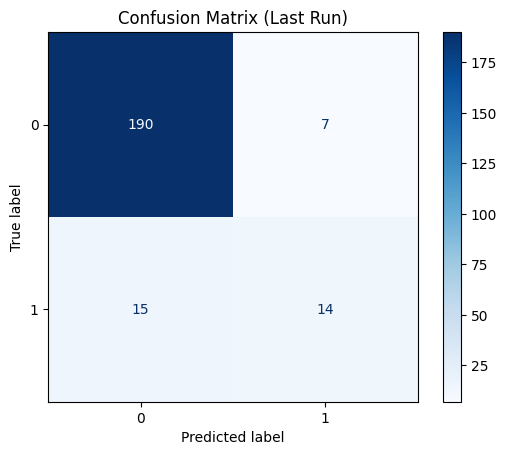

In [13]:
########## 7. Aggregate and Visualize Results ##########
# Calculate mean and standard deviation
results = {
    'Metric': ['Precision', 'Recall', 'F1'],
    'Mean': [
        np.mean(metrics['Precision']),
        np.mean(metrics['Recall']),
        np.mean(metrics['F1'])
    ],
    'Std': [
        np.std(metrics['Precision']),
        np.std(metrics['Recall']),
        np.std(metrics['F1'])
    ]
}

# Print final results
results_df = pd.DataFrame(results)
print("\n=== Final Evaluation Results ===")
print(results_df)

# Plot confusion matrix for the last run
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Last Run)')
plt.savefig('confusion_matrix.png')
plt.show()

# Save results to CSV
results_df.to_csv('improved_svm_results.csv', index=False)